***
*Project:* Helmholtz Machine on Niche Construction

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Experiment 2</span> 

# Helmholtz Machine as Biased Generator

By experiment, I found that the Helmholtz machine is a biased generator under the original training mechanism. In this notebook,  I will further examine the property of the Helmholtz machine and hope to train a generator that recovers not only the data but also its distribution by modifying the local delta rule.

*Updated:* December 9, 2023


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n = 10
well_formed_set = np.zeros([1,n])
well_formed_set[0,0] = 1

for i in range(1,n):
    for j in range(np.shape(well_formed_set)[0]):
        if i == 2 and np.array_equal(well_formed_set[j,i-2:i], [1,0]):
            well_formed_set[j,i] = 1
        elif i > 3 and np.array_equal(well_formed_set[j,i-3:i], [0,0,0]):
            well_formed_set[j,i] = 1
        elif i > 3 and np.array_equal(well_formed_set[j,i-4:i], [0,0,1,0]):
            well_formed_set[j,i] = 1
        else:
            well_formed_set = np.append(well_formed_set, well_formed_set[j:j+1,:], axis=0)
            well_formed_set[j,i] = 1
            
ind = np.array([], dtype=np.int8)
for i in range(well_formed_set.shape[0]):
    if np.array_equal(well_formed_set[i,-3:], [0,0,1]):
        ind = np.append(ind,i)

well_formed_set = np.delete(well_formed_set,ind,0)
well_formed_set = (well_formed_set - 0.5)*2
well_formed_set = np.transpose(well_formed_set)
well_formed_set

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -1.,  1., ...,  1., -1.,  1.],
       [ 1.,  1., -1., ...,  1.,  1., -1.],
       ...,
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.]])

In [3]:
well_formed_set.shape

(10, 256)

The Helmholtz machine structure is given as below:

<img src="Helmz.jpg" style="width:550px">
<caption><center> **Figure 4**: The Helmholtz Machine  </center></caption>

I previously wrote in Document 2 about the variational objective function and deduction of the parameter updating rules of the Helmholtz machine, and I will give a more systematic analysis on these matters in upcoming notebooks, so here let's skip these steps and say we know the parameter updating local delta rule is as follows:

$$
\frac{\partial \tilde{F}}{\partial \phi_{k,n}^{m-1,m}} = \left \{
\begin{array}{ll}
-s_k^{m-1}(1-q_n^m) & \text{if } s_n^m = 1 \\
s_k^{m-1} \centerdot q_n^m & \text{if } s_n^m = -1
\end{array} \right.
$$

$$
\frac{\partial F}{\partial \theta_{k,n}^{m+1,m}} = \left \{
\begin{array}{ll}
-s_k^{m+1}(1-p_n^m) & \text{if } s_n^m = 1 \\
s_k^{m+1} \centerdot p_n^m & \text{if } s_n^m = -1
\end{array} \right.
$$

Let's write the functions to run this model...

We always have the bottom layer as data input, denoted as $d_0$. In our case illustrated in Figure 4, we have $m = 4$ layers, with various numbers of neurons, $n_{d_0} = 10$, $n_{z_1} = 8$, $n_{z_2} = 5$, $n_{z_3} = 3$. These are the hyperparameters to initialize the model.

In [4]:
def parameter_initialization(init_type,n_dz):
    """
    Arguments:
    init_type -- "zero" or "random", "zero" assigns 0 to all parameters, "random" samples from standard Gaussian
    n_dz -- number of neurons for each layer, numpy array of shape (m, ), where m is the number of layers
    
    Returns:
    Phi -- Recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    """
    Phi = {}
    Theta = {}
    m = len(n_dz)
    if init_type == "zero":
        for i in range(m-1):
            Phi["Phi_" + str(i) + str(i+1)] = np.zeros((n_dz[i+1],n_dz[i]+1))
            Theta["Theta_" + str(i+1) + str(i)] = np.zeros((n_dz[i],n_dz[i+1]+1))
        Theta["Theta_k"] = np.zeros((n_dz[-1],1))
    elif init_type == "random":
        for i in range(m-1):
            Phi["Phi_" + str(i) + str(i+1)] = np.random.randn(n_dz[i+1],n_dz[i]+1)
            Theta["Theta_" + str(i+1) + str(i)] = np.random.randn(n_dz[i],n_dz[i+1]+1)
        Theta["Theta_k"] = np.random.randn(n_dz[-1],1)
    else:
        raise Exception("Wrong Init Type")
    return Phi, Theta

In [5]:
n_dz = np.array([10,8,5,3])
init_type = "random"
Phi, Theta = parameter_initialization(init_type,n_dz)

In [6]:
def sigmoid(x):
    y = 1/(1+np.exp(-x))
    return y

In [79]:
def wake_forward(d0,Phi):
    """
    Arguments:
    d0 -- input pattern, numpy array of shape (n_d, 1)
    Phi -- Recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    
    Returns:
    Q -- Probability of sampled recognition assignment, number in (0,1)
    Alpha_Q -- assignment of each neuron (binary value), Python dictionary of length len(Phi)+1 with each key-value pair being 
    a numpy array of shape (n_z, 1)
    """
    n = len(Phi)
    S = d0  # assignment of each layer
    Q = 1
    Alpha_Q = {"z0":d0}
    for i in range(n):
        phi = Phi["Phi_" + str(i) + str(i+1)]
        q = sigmoid(np.matmul(phi,np.append(S,[[1]], axis=0)))
        S = ((q > np.random.rand(len(q),1)).astype(int) - 0.5)*2    # rejection sampling
        Q = Q * np.cumprod(S*q + (1-S)/2)[-1] * 2**q.size  # S takes {-1,1}
        Alpha_Q["z"+str(i+1)] = S
    return Q, Alpha_Q

In [82]:
Q, Alpha_Q = wake_forward(d0,Phi)
Q

353.1439503620823

In [72]:
def wake_forward_expectation(d0,Phi):
    """
    Arguments:
    d0 -- input pattern, numpy array of shape (n_d, 1)
    Phi -- Recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    
    Returns:
    Q -- Probability of sampled recognition assignment, number in (0,1)
    Alpha_Q -- assignment of each neuron (binary value), Python dictionary of length len(Phi)+1 with each key-value pair being 
    a numpy array of shape (n_z, 1)
    """
    n = len(Phi)
    S = d0  # assignment of each layer
    Alpha_Q = {"z0":d0}
    for i in range(n):
        phi = Phi["Phi_" + str(i) + str(i+1)]
        q = sigmoid(np.matmul(phi,np.append(S,[[1]], axis=0))) 
        S = q  # use q as expectation assignment, which indicates the hidden units binary values take {0,1}
        Alpha_Q["z"+str(i+1)] = q
    return Alpha_Q

In [73]:
d0 = well_formed_set[:,5:6]

In [89]:
Alpha_Q = wake_forward_expectation(d0,Phi)

In [84]:
def sleep_forward(Theta):
    """
    Arguments:
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    
    Returns:
    P -- Probability of sampled generative assignment, number in (0,1)
    Alpha_P -- assignment of each neuron (binary value), Python dictionary of same length as Theta with each key-value pair being 
    a numpy array of shape (n_z, 1)
    """
    theta = Theta["Theta_k"]
    p = sigmoid(theta)
    S = ((p > np.random.rand(len(p),1)).astype(int) - 0.5)*2
    
    m = len(Theta)
    P = np.cumprod(S*p + (1-S)/2)[-1] * 2**p.size
    Alpha_P = {"z"+str(m-1):S}
    
    for i in range(m-1,0,-1):
        theta = Theta["Theta_" + str(i) + str(i-1)]
        p = sigmoid(np.matmul(theta,np.append(S,[[1]], axis=0)))
        S = ((p > np.random.rand(len(p),1)).astype(int) - 0.5)*2    # rejection sampling
        P = P * np.cumprod(S*p + (1-S)/2)[-1] * 2**p.size
        Alpha_P["z"+str(i-1)] = S
    return P, Alpha_P

In [85]:
P, Alpha_P= sleep_forward(Theta)
P

25.73143630509956

In [83]:
def sleep_forward_expectation(Theta):
    """
    Arguments:
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    
    Returns:
    P -- Probability of sampled generative assignment, number in (0,1)
    Alpha_P -- assignment of each neuron (binary value), Python dictionary of same length as Theta with each key-value pair being 
    a numpy array of shape (n_z, 1)
    """
    theta = Theta["Theta_k"]
    p = sigmoid(theta)
    S = p # use p as expectation assignment, which indicates the hidden units binary values take {0,1}
    
    m = len(Theta)
    Alpha_P = {"z"+str(m-1):S}
    
    for i in range(m-1,1,-1):
        theta = Theta["Theta_" + str(i) + str(i-1)]
        p = sigmoid(np.matmul(theta,np.append(S,[[1]], axis=0)))
        S = p # use p as expectation assignment, which indicates the hidden units binary values take {0,1}
        Alpha_P["z"+str(i-1)] = S
    p = sigmoid(np.matmul(Theta["Theta_10"],np.append(S,[[1]], axis=0)))
    S = ((p > np.random.rand(len(p),1)).astype(int) - 0.5)*2    # rejection sampling for output
    Alpha_P["z0"] = S
    return Alpha_P

- **Expectation rule**

$$
\frac{\partial \tilde{F}}{\partial \phi_{k,n}^{m-1,m}} = s_k^{m-1}(q_n^m - p_n^m)
$$
$$
\frac{\partial F}{\partial \theta_{k,n}^{m+1,m}} = s_k^{m+1}(p_n^m - q_n^m)
$$

In [103]:
def wake_update_delta(Phi,Alpha_P,lr):
    
    """
    Arguments:
    Phi -- Recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    Alpha_P -- Generative assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
    a numpy array of shape (n_z, 1)
    lr -- learning rate, decimals
    
    Returns:
    Phi -- Updated recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    info_gain_wake -- information gain of each neuron by single update, quantifies the error and the amount of parameter change 
    associated with each neuron, Python dictionary of length m-1 with each key-value pair being a numpy array of shape (n_z, 1)
    error_Q -- cumsum of all terms in info_gain_wake, a measurement of discrepancy between the generative assignment and 
    the recognition model
    """
    n = len(Phi)
    info_gain_wake = {}
    error_Q = 0
    for i in range(n):
        S_bias = np.append(Alpha_P["z"+str(i)],[[1]], axis=0)
        q = sigmoid(np.matmul(Phi["Phi_" + str(i) + str(i+1)],S_bias))
        gain = q - (1+Alpha_P["z"+str(i+1)])/2
        Phi["Phi_" + str(i) + str(i+1)] -= lr * np.outer(gain,S_bias)
        info_gain_wake["z"+str(i+1)] = gain # positive(s=-1) & negative(s=1)
        error_Q += (np.abs(gain)).sum()
    
    return Phi, info_gain_wake,error_Q

In [94]:
lr = 0.1

In [105]:
Phi, info_gain_wake,error_Q = wake_update_delta(Phi,Alpha_P,lr)

From the information gain, we can read the error of the given assignment *Alpha_P* for parameters *Phi*, on each neuron it computes. The value of info_gain is within $[-1,1]$, where positive value indicates the current neuron takes value $-1$, while negative value indicates that the current neuron takes value $1$. 

In [91]:
def wake_update_expectation(Phi,Alpha_P,lr):
    
    """
    Arguments:
    Phi -- Recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    Alpha_P -- Generative assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
    a numpy array of shape (n_z, 1)
    lr -- learning rate, decimals
    
    Returns:
    Phi -- Updated recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    info_gain_wake -- information gain of each neuron by single update, quantifies the error and the amount of parameter change 
    associated with each neuron, Python dictionary of length m-1 with each key-value pair being a numpy array of shape (n_z, 1)
    error_Q -- cumsum of all terms in info_gain_wake, a measurement of discrepancy between the generative assignment and 
    the recognition model
    """
    n = len(Phi)
    info_gain_wake = {}
    error_Q = 0
    
    for i in range(n):
        S_bias = np.append(Alpha_P["z"+str(i)],[[1]], axis=0)
        q = sigmoid(np.matmul(Phi["Phi_" + str(i) + str(i+1)],S_bias))
        gain = q - Alpha_P["z"+str(i+1)]
        Phi["Phi_" + str(i) + str(i+1)] -= lr * np.outer(gain,S_bias)
        info_gain_wake["z"+str(i+1)] = gain # positive(s=-1) & negative(s=1)
        error_Q += (np.abs(gain)).sum()
    
    return Phi, info_gain_wake,error_Q

In [95]:
Phi, info_gain_wake,error_Q = wake_update_expectation(Phi,Alpha_P,lr)

In [124]:
def sleep_update_delta(Theta,Alpha_Q,lr):
    
    """
    Arguments:
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    Alpha_Q -- Recognition assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
    a numpy array of shape (n_z, 1)
    
    Returns:
    Theta -- Updated generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    info_gain_sleep -- information gain of each neuron by single update, quantifies the error and the amount of parameter change 
    associated with each neuron, Python dictionary of length m-1 with each key-value pair being a numpy array of shape (n_z, 1)
    error_P -- cumsum of all terms in info_gain_sleep, a measurement of discrepancy between the recognition assignment and 
    the generative model
    """
    n = len(Theta)
    info_gain_sleep = {}
    error_P = 0
    
    p = sigmoid(Theta["Theta_k"])
    gain = p - (1+Alpha_Q["z"+str(n-1)])/2
    Theta["Theta_k"] -= lr * gain
    info_gain_sleep["z"+str(n-1)] = gain
    error_P += (np.abs(gain)).sum()
    
    for i in range(n-1,0,-1):
        S_bias = np.append(Alpha_Q["z"+str(i)],[[1]], axis=0)
        p = sigmoid(np.matmul(Theta["Theta_" + str(i) + str(i-1)],S_bias))
        gain = p - (1+Alpha_Q["z"+str(i-1)])/2
        Theta["Theta_" + str(i) + str(i-1)] -= lr * np.outer(gain,S_bias)
        info_gain_sleep["z"+str(i-1)] = gain # positive(s=-1) & negative(s=1)
        error_P += (np.abs(gain)).sum()
    
    return Theta, info_gain_sleep, error_P

In [100]:
def sleep_update_expectation(Theta,Alpha_Q,lr):
    
    """
    Arguments:
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    Alpha_Q -- Recognition assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
    a numpy array of shape (n_z, 1)
    
    Returns:
    Theta -- Updated generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    info_gain_sleep -- information gain of each neuron by single update, quantifies the error and the amount of parameter change 
    associated with each neuron, Python dictionary of length m-1 with each key-value pair being a numpy array of shape (n_z, 1)
    error_P -- cumsum of all terms in info_gain_sleep, a measurement of discrepancy between the recognition assignment and 
    the generative model
    """
    n = len(Theta)
    info_gain_sleep = {}
    error_P = 0
    
    p = sigmoid(Theta["Theta_k"])
    gain = p - Alpha_Q["z"+str(n-1)]
    Theta["Theta_k"] -= lr * gain
    info_gain_sleep["z"+str(n-1)] = gain
    error_P += (np.abs(gain)).sum()
    
    for i in range(n-1,1,-1):
        S_bias = np.append(Alpha_Q["z"+str(i)],[[1]], axis=0)
        p = sigmoid(np.matmul(Theta["Theta_" + str(i) + str(i-1)],S_bias))
        gain = p - Alpha_Q["z"+str(i-1)]
        Theta["Theta_" + str(i) + str(i-1)] -= lr * np.outer(gain,S_bias)
        info_gain_sleep["z"+str(i-1)] = gain # positive(s=-1) & negative(s=1)
        error_P += (np.abs(gain)).sum()
        
    S_bias = np.append(Alpha_Q["z1"],[[1]], axis=0)
    p = sigmoid(np.matmul(Theta["Theta_10"],S_bias))
    gain = p - (1+Alpha_Q["z0"])/2
    Theta["Theta_10"] -= lr * np.outer(gain,S_bias)
    info_gain_sleep["z0"] = gain # positive(s=-1) & negative(s=1)
    error_P += (np.abs(gain)).sum()
    
    return Theta, info_gain_sleep, error_P

### Expectation Training Method

In [103]:
# dataset
well_formed_set.shape

(10, 256)

In [157]:
# parameters
n_dz = np.array([10,8,5,3])
init_type = "random"
Phi, Theta = parameter_initialization(init_type,n_dz)

Like stochastic gradient descent, we update the parameters for each data input (no batch).

In [158]:
n_q = n_dz[1:].sum()
n_p = n_dz.sum()
lr = 0.05
epoch = 300
n_data = well_formed_set.shape[1]

for e in range(epoch):
    error_P_all = 0
    error_Q_all = 0
    for i in range(n_data):
        d0 = well_formed_set[:,i:i+1]
        Alpha_Q = wake_forward_expectation(d0,Phi)
        Theta, info_gain_sleep, error_P = sleep_update_expectation(Theta,Alpha_Q,lr)
        error_P_all += error_P/n_p

        Alpha_P = sleep_forward_expectation(Theta)
        Phi, info_gain_wake,error_Q = wake_update_expectation(Phi,Alpha_P,lr)
        error_Q_all += error_Q/n_q

    error_P_all = error_P_all/n_data
    error_Q_all = error_Q_all/n_data
    print(error_P_all,error_Q_all)

0.22976467598426914 0.0998830132602375
0.16198684112214215 0.02003261412546685
0.1488447123489608 0.00557447666957883
0.14532844522800833 0.0022320495561867775
0.1445487361742158 0.0012723708157633157
0.14389617260390217 0.00036119492996504216
0.14386894592540866 0.0004815711459145259
0.14379846219334358 0.0002378820664904722
0.14356088925989383 6.383666025583678e-05
0.14381797336787555 0.00048419803399050814
0.14365522276394863 0.00014742970336214986
0.14351956539466196 4.614003318067569e-05
0.14347577968748187 1.5580761305048133e-05
0.14345795393688685 6.231388974197892e-06
0.14344851990459864 2.276146520173093e-06
0.14379289093023415 0.0004849002515404571
0.14353513530156956 8.577231936732029e-05
0.14347466891231292 3.126958523844601e-05
0.14345388422557961 1.0778200474256022e-05
0.14344634678927784 5.4506945984488236e-06
0.14388741811966804 0.0007333641424032892
0.1437289888396802 0.00020758129454119696
0.14352101986706198 5.226815254661716e-05
0.1434666759976685 1.676668778443905e

0.14349332501856965 4.396973690934385e-05
0.1434638119813436 1.4717102412614632e-05
0.14345319555211922 6.025328880621728e-06
0.14344888406130113 2.5237906841068345e-06
0.14344703199258205 1.2011400551109117e-06
0.1436610031848033 0.0002904127691555871
0.14361101938587612 0.00011824404931537442
0.1434958773955706 3.117049062912567e-05
0.14346406338654177 8.601230814547875e-06
0.14345579974999909 2.796285700143378e-06
0.14345321083002574 9.264992701183013e-07
0.143452415370206 3.6278273525267913e-07
0.14345205026410707 1.6103326872883014e-07
0.14345189906164685 7.542820404030223e-08
0.14345182358989172 2.9469277950058977e-08
0.1434517852026696 1.3208630784707737e-08
0.1434517588590751 6.140256783536131e-09
0.1434517391461197 3.1344722368597654e-09
0.14345172081318724 1.3442331415800088e-09
0.14345170372522822 5.848049042093441e-10
0.14345168728080057 3.0287337951349783e-10
0.1434516711808711 1.3423515198566138e-10
0.1434516553300886 6.283019016086605e-11
0.1434516396655082 3.04548090373

Let's generate with this model...

In [246]:
def generate(Theta):
    """
    Arguments:
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    
    Returns:
    S -- generation of one instance, numpy array of shape (n_d, )
    """
    theta = Theta["Theta_k"]
    p = sigmoid(theta)
    S = ((p > np.random.rand(len(p),1)).astype(int) - 0.5)*2
    m = len(Theta)
    for i in range(m-1,0,-1):
        theta = Theta["Theta_" + str(i) + str(i-1)]
        p = sigmoid(np.matmul(theta,np.append(S,[[1]], axis=0)))
        S = ((p > np.random.rand(len(p),1)).astype(int) - 0.5)*2    # rejection sampling
    return S

In [116]:
def generate_expectation(Theta, gen_type):
    """
    Arguments:
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    
    Returns:
    S -- generation of one instance, numpy array of shape (n_d, )
    """
    theta = Theta["Theta_k"]
    p = sigmoid(theta)
    if gen_type == "sampling":
        S = (p > np.random.rand(len(p),1)).astype(int)
    else:
        S = p
    m = len(Theta)
    for i in range(m-1,1,-1):
        theta = Theta["Theta_" + str(i) + str(i-1)]
        p = sigmoid(np.matmul(theta,np.append(S,[[1]], axis=0)))
        if gen_type == "sampling":
            S = (p > np.random.rand(len(p),1)).astype(int)   # rejection sampling
        else:
            S = p
    p = sigmoid(np.matmul(Theta["Theta_10"],np.append(S,[[1]], axis=0)))
    S = ((p > np.random.rand(len(p),1)).astype(int) - 0.5)*2
    return S

We want to examine the distribution of generation. We let the model generate, say 10000 instances, then use the samples to approximate its generative distribution.

In [159]:
n_sample = 10000
generation = np.zeros((n_dz[0],n_sample))
for i in range(n_sample):
    generation[:,i:i+1] = generate_expectation(Theta, "sampling")

We know there are 1024 combinations in total, which gives 1024 categories. Here we use integer numbers 0-1023 to represent these combinations and for visualization, we assign 0-255 as our well-formed set.

In [120]:
n = 10
entire_set = np.zeros((2,10))
entire_set[0,0] = 1
for i in range(1,n):
    for j in range(entire_set.shape[0]):
        entire_set = np.append(entire_set, entire_set[j:j+1,:], axis=0)
        entire_set[j,i] = 1
entire_set = (entire_set - 0.5)*2
entire_set = np.transpose(entire_set)
entire_set

array([[ 1., -1.,  1., ..., -1.,  1., -1.],
       [ 1.,  1., -1., ...,  1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       ...,
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.]])

In [121]:
entire_set = np.unique(entire_set, axis=1)
well_formed_set = np.unique(well_formed_set, axis=1)
reordered_set = np.zeros(entire_set.shape)
reordered_set[:,:well_formed_set.shape[1]] = well_formed_set

k = well_formed_set.shape[1]
for i in range(entire_set.shape[1]):
    flag = 0
    for j in range(well_formed_set.shape[1]):
        if np.array_equal(entire_set[:,i], well_formed_set[:,j]):
            flag = 1
            break
    if flag == 0:
        reordered_set[:,k] = entire_set[:,i]
        k += 1
reordered_set

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [-1., -1., -1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [-1., -1.,  1., ..., -1., -1., -1.],
       [ 1.,  1., -1., ..., -1., -1., -1.],
       [-1.,  1., -1., ..., -1.,  1.,  1.]])

In reordered_set, we set the first 256 columns as the well-formed set and the rest as negative samples outside of well-formed bound. Now we calculate the distribution of generation.

In [160]:
distribution = np.zeros((generation.shape[1], ),dtype = int)
for i in range(generation.shape[1]):
    for j in range(reordered_set.shape[1]):
        if np.array_equal(generation[:,i], reordered_set[:,j]):
            distribution[i] = j
            break

In [161]:
distribution

array([243, 252, 201, ...,  32, 229, 209])

In [162]:
values, counts = np.unique(distribution, return_counts=True)
counts.size

441

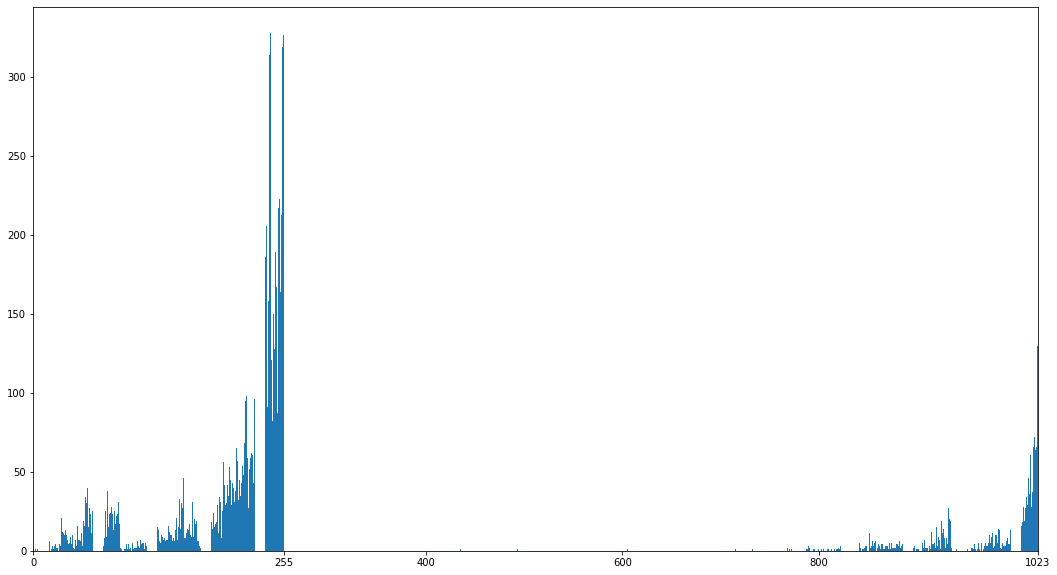

In [163]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(values,counts)
ax.set(xlim=(0, 1023), xticks=np.array([0,255,400,600,800,1023]))
plt.show()

In [164]:
# Percentage of correct instances among all generations
counts[values < 256].sum()/generation.shape[1]

0.8435

In [165]:
counts[values < 256].size

248

In [166]:
statistics = np.array([values, counts])
for i in range(values.size-1):
    diff = values[i+1] - values[i]
    for j in range(1,diff):
        statistics = np.append(statistics, np.array([[values[i]+j],[0]]),axis = 1)
statistics = np.unique(statistics,axis = 1)
statistics[1,0:256]

array([  1,   0,   1,   0,   1,   0,  11,   6,   7,   5,   2,   5,   4,
         6,   4,   6,   4,   6,   0,   1,   3,   1,   3,   4,   2,   2,
         0,   4,   3,  21,  12,  11,  10,  13,  10,   7,   4,   5,   9,
         4,  10,   2,   1,   7,   3,  16,   7,   7,   6,  11,   3,  19,
        16,  34,  30,  40,  15,  27,  23,  11,  25,  18,  33,  22,   9,
         5,   6,  12,   6,   6,  16,  12,   3,   8,  25,   9,  38,  15,
        23,  24,  28,  23,  13,  25,  17,  22,  23,  31,  17,   2,   1,
         0,   0,   1,   1,   4,   1,   4,   1,   2,   0,   5,   1,   2,
         2,   2,   6,   3,   2,   7,   4,   5,   5,   1,   5,   3,   2,
         9,   3,   6,   8,   8,   6,   7,   8,  11,  24,  15,  13,   6,
         5,  10,   9,   7,   8,   6,   7,   7,  16,  12,  10,  10,   6,
         8,   6,  13,  21,   7,  15,  33,  14,  30,  27,  46,   8,   8,
        11,  14,  13,  17,  10,   9,  31,   9,  20,  17,  19,   6,   6,
         3,   2,   5,  10,  10,  11,  16,   9,  11,  18,  16,   

In [167]:
Theta

{'Theta_10': array([[ 0.48353902,  1.62643856,  1.97819237,  1.672384  ,  0.8772383 ,
          2.82323708,  0.12645715,  0.65330562,  3.03327121],
        [ 1.20807793,  0.78771601,  2.68433376,  1.05228895,  1.2821227 ,
         -1.96009945,  2.27746462,  0.52836295, -0.73190118],
        [-0.14412266,  0.56010536,  0.77658523,  0.94079198,  1.07937709,
          0.05195837, -0.39628455, -1.37831183,  0.99075065],
        [ 0.17174982,  0.78778258,  0.36371727, -1.54016735,  0.52372244,
         -0.19732077,  0.52564788,  0.2706051 ,  1.58925647],
        [ 0.66079355, -1.54666492,  1.34478288,  2.16108398,  0.14279446,
          0.10313312,  0.30086041, -0.08404553, -0.50601995],
        [ 0.18979941,  1.86013072, -1.08473127,  1.00194203, -0.35596614,
          0.36210117, -2.01470296, -0.39067427,  0.06588787],
        [ 0.88308429,  0.05063965,  1.41195692, -0.79069707,  1.06200532,
         -0.68721921, -0.78442672,  0.37673018,  0.29362181],
        [ 0.20635206,  0.6845116 ,  

### Variational Training Method

**Weighted local delta rule**

$$
\frac{\partial F}{\partial \theta_{k,n}^{m+1,m}} = \left \{
\begin{array}{ll}
-\sum_\alpha Q_\phi(\alpha|d_0)s_k^{m+1}(1-p_n^m) & \text{if } s_n^m = 1 \\
\sum_\alpha Q_\phi(\alpha|d_0)s_k^{m+1} \centerdot p_n^m & \text{if } s_n^m = -1
\end{array} \right.
$$
$$
\frac{\partial \tilde{F}}{\partial \phi_{k,n}^{m-1,m}} = \left \{
\begin{array}{ll}
- \sum_{\alpha} P_\theta(\alpha,d_0)s_k^{m-1}(1-q_n^m) & \text{if } s_n^m = 1 \\
\sum_{\alpha} P_\theta(\alpha,d_0)s_k^{m-1} \centerdot q_n^m & \text{if } s_n^m = -1
\end{array} \right.
$$

It's impossible to sum over the complete assignments. Instead, we sample a subset of assignments and train with its weighted summation.

In [ ]:
def wake_forward_sample(d0,Phi,k):
    """
    Arguments:
    d0 -- input pattern, numpy array of shape (n_d, 1)
    Phi -- Recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    k -- number of instances sampled
    
    Returns:
    Q -- Probability of sampled recognition assignment, number in (0,1)
    Alpha_Q -- assignment of each neuron (binary value), Python dictionary of length len(Phi)+1 with each key-value pair being 
    a numpy array of shape (n_z, 1)
    """
    n = len(Phi)
    S = d0  # assignment of each layer
    Q = 1
    Alpha_Q = {"z0":d0}
    for i in range(n):
        phi = Phi["Phi_" + str(i) + str(i+1)]
        q = sigmoid(np.matmul(phi,np.append(S,[[1]], axis=0)))
        S = ((q > np.random.rand(len(q),1)).astype(int) - 0.5)*2    # rejection sampling
        Q = Q * np.cumprod(S*q + (1-S)/2)[-1] * 2**q.size  # S takes {-1,1}
        Alpha_Q["z"+str(i+1)] = S
    return Q, Alpha_Q